# What Drives Nurse Turnover?
###### Yun Yu

## Read Data

In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import scipy.stats as ss
from itertools import product

In [2]:
# read file
for i in os.listdir():
    if i.endswith(".csv"):
        qfd = pd.read_csv(i)

In [3]:
# print all columns
for ind, col in enumerate(qfd):
    print(ind, col)

0 years_in_profession
1 cur_highest_license
2 cur_licensed_state
3 cur_licensed_state_type
4 age_group
5 gender
6 highest_education
7 year_of_first_license
8 len_of_cur_license_level
9 is_cur_acute_facility
10 cur_type_of_facility
11 cur_type_of_facility_other
12 cur_acute_unit_group
13 cur_acute_unit
14 cur_acute_unit_other
15 was_nurse_traveler
16 is_nurse_traveler
17 annual_range_as_of_2019
18 cur_annual_range
19 is_job_change_since_2019
20 total_jobs_changed
21 plan_to_change_next_6mo
22 plan_to_leave_nursing
23 cur_work_schedule
24 cur_work_schedule_other
25 cur_total_hour_work
26 cur_shift_type
27 cur_shift_type_other


In [4]:
# craete datafreme that excludes likert scale
sdf = qfd

## Cleaning

In [5]:
# get basic info
sdf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 28 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   years_in_profession         118 non-null    int64  
 1   cur_highest_license         118 non-null    object 
 2   cur_licensed_state          118 non-null    object 
 3   cur_licensed_state_type     118 non-null    object 
 4   age_group                   118 non-null    object 
 5   gender                      118 non-null    object 
 6   highest_education           118 non-null    object 
 7   year_of_first_license       118 non-null    int64  
 8   len_of_cur_license_level    118 non-null    object 
 9   is_cur_acute_facility       116 non-null    object 
 10  cur_type_of_facility        116 non-null    object 
 11  cur_type_of_facility_other  18 non-null     object 
 12  cur_acute_unit_group        117 non-null    object 
 13  cur_acute_unit              76 non-

In [6]:
# print unique vlaues of each column
for i in sdf.columns:
    print(i, ":", sdf[i].unique(), "\n\n")

years_in_profession : [ 4 17 14 16 28  3 25 37  9  1 33 46 27 15 18 21  6 12 24 26 11 39  8  5
 38  7 42 29 20 35 40  2 23 19 13  0 10 30] 


cur_highest_license : ['Registered nurse' 'Nurse practitioner' 'Licensed practical nurse'] 


cur_licensed_state : ['Colorado' 'Kansas compact license ' 'Colorado- compact'
 'Colorado(compact license), California ' 'CO' 'Pa and co'
 'Colorado Compact State' 'Colorado and all compact states.'
 'Colorado multi state license ' 'Colorado ' 'Colorado and compact states'
 'ks' 'Colorado-compact states' 'Arizona' 'Colorado, Oregon, Washington '
 'WA, OR, CA' 'OR' 'Nebraska' 'New York ' 'Oregon ' 'Oregon   California '
 'Oregon and Washington ' 'Washington and Oregon' 'AZ'
 'Colorado, Oregon, California, Tennessee'
 'Arkansas - Multi State license ' 'Colorado, compact nursing license'
 'Iowa, Colorado'
 'I have a compact license in the state of Florida and a license in NY. '
 'Co, HI,  WA ' 'Washington, Oklahoma (not compact)' 'OR  WA  UT  ' 'WA'
 'WA  C

In [7]:
# drop NAs in "plan_to_change_next_6mo"
cd = sdf.dropna(subset=["plan_to_change_next_6mo"])

In [8]:
# drop NAs in "is_nurse_traveler" and "cur_annual_range"
cd.drop(cd[cd["is_nurse_traveler"].isnull() | cd["cur_annual_range"].isnull() | cd["cur_total_hour_work"].isnull()].index, inplace=True)

/Users/ryry/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [9]:
# check "cur_type_of_facility" null
cd[cd["cur_type_of_facility"].isnull()][["cur_type_of_facility_other", "cur_acute_unit", "cur_acute_unit_group"]]

,cur_type_of_facility_other,cur_acute_unit,cur_acute_unit_group
7,NaN,OB / Women and Infants (including mother / bab...,OB-GYN


In [10]:
# fix "cur_type_of_facility" null error
cd["cur_type_of_facility"] = np.where(cd["cur_type_of_facility"].isnull(), "Acute care hospital", cd["cur_type_of_facility"])
cd["is_cur_acute_facility"] = np.where(cd["is_cur_acute_facility"].isnull(), "Yes", cd["is_cur_acute_facility"])

<ipython-input-10-ab46aa5d8e70>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd["cur_type_of_facility"] = np.where(cd["cur_type_of_facility"].isnull(), "Acute care hospital", cd["cur_type_of_facility"])
<ipython-input-10-ab46aa5d8e70>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd["is_cur_acute_facility"] = np.where(cd["is_cur_acute_facility"].isnull(), "Yes", cd["is_cur_acute_facility"])


In [11]:
# drop current inactive participant
cd.drop(cd[(cd["cur_type_of_facility_other"]=="Retired") | (cd["cur_type_of_facility_other"]=="unemployed") | (cd["cur_type_of_facility_other"]=="I’ve left the profession at this current time")].index, inplace=True)

/Users/ryry/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [12]:
# drop observations have quality issue
cd.drop(cd[(cd["is_job_change_since_2019"]=="Yes")&(cd["total_jobs_changed"]==0)].index, inplace=True)
# fix values 
cd["cur_work_schedule"] = np.where(cd["cur_work_schedule_other"]=="Travel and prn", "Per Diem / PRN", cd["cur_work_schedule"])
cd["cur_shift_type"] = np.where(cd["cur_shift_type_other"]=="12 hour evening shift", "12 hr -night shift", cd["cur_shift_type"])
cd["cur_acute_unit"] = np.where(cd["cur_acute_unit_other"]=="OB and NICU", "OB / Women and Infants (including mother / baby or postpartum)", cd["cur_acute_unit"])
cd["cur_acute_unit_group"] = np.where(cd["cur_acute_unit_other"]=="OB and NICU", "OB-GYN", cd["cur_acute_unit_group"])
cd["highest_education"] = np.where(cd["highest_education"]=="Clinical Doctorate", "PhD", cd["highest_education"])

/Users/ryry/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-12-4924f15178b2>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd["cur_work_schedule"] = np.where(cd["cur_work_schedule_other"]=="Travel and prn", "Per Diem / PRN", cd["cur_work_schedule"])
<ipython-input-12-4924f15178b2>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [13]:
# group work hours
## create function
def work_hr_group(hr):
    if hr == "12" or hr == "15-20" or hr == "<12hrs" or hr == "18":
        return "<20"
    elif hr == "24-36" or hr == "36" or hr == "24" or hr == "38" or hr == "32" or hr == "30" or hr == "16-24" or hr == "37.5" or hr == "35" or hr == "36-40" or hr == "38-40": 
        return "20-40"
    elif hr == "40+" or hr == "45" or hr == "40" or hr == "40-45" or hr == "42" or hr == "50" or hr == "36-48 hours" or hr == "36-48" or hr == "36+" or hr == "40 +" or hr == "48" or hr == "43" or hr == "36 to 48" or hr == "44 to 56" or hr == "45 to 50":
        return "41-50"
    elif hr == "60" or hr == "60-70" or hr == "50-60" or hr == "50 - 60" or hr == "50-55" or hr == "55" or hr == "55+":
        return ">50"
    else: 
        return hr
## store group to a new column
cd["cur_total_hour_work_group"] = cd.apply(lambda x: work_hr_group(x["cur_total_hour_work"]), axis=1)

<ipython-input-13-5ff1134ff27e>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cd["cur_total_hour_work_group"] = cd.apply(lambda x: work_hr_group(x["cur_total_hour_work"]), axis=1)


In [14]:
cd.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 99 entries, 1 to 117
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   years_in_profession         99 non-null     int64  
 1   cur_highest_license         99 non-null     object 
 2   cur_licensed_state          99 non-null     object 
 3   cur_licensed_state_type     99 non-null     object 
 4   age_group                   99 non-null     object 
 5   gender                      99 non-null     object 
 6   highest_education           99 non-null     object 
 7   year_of_first_license       99 non-null     int64  
 8   len_of_cur_license_level    99 non-null     object 
 9   is_cur_acute_facility       99 non-null     object 
 10  cur_type_of_facility        99 non-null     object 
 11  cur_type_of_facility_other  12 non-null     object 
 12  cur_acute_unit_group        99 non-null     object 
 13  cur_acute_unit              67 non-n

In [15]:
# create EDA df
eda = cd.iloc[:, np.r_[:2, 3:10, 12, 15:24, 26, 28]].reset_index(drop=True)
eda.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99 entries, 0 to 98
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   years_in_profession        99 non-null     int64  
 1   cur_highest_license        99 non-null     object 
 2   cur_licensed_state_type    99 non-null     object 
 3   age_group                  99 non-null     object 
 4   gender                     99 non-null     object 
 5   highest_education          99 non-null     object 
 6   year_of_first_license      99 non-null     int64  
 7   len_of_cur_license_level   99 non-null     object 
 8   is_cur_acute_facility      99 non-null     object 
 9   cur_acute_unit_group       99 non-null     object 
 10  was_nurse_traveler         99 non-null     object 
 11  is_nurse_traveler          99 non-null     object 
 12  annual_range_as_of_2019    99 non-null     object 
 13  cur_annual_range           99 non-null     object 
 

In [16]:
# change data type
eda["total_jobs_changed"] = eda["total_jobs_changed"].astype(int)

## EDA

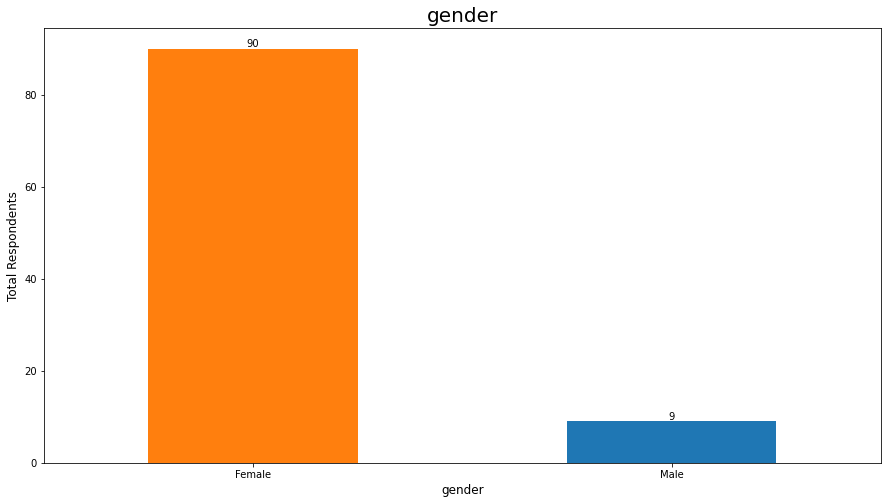

In [17]:
# gender
gender = eda.groupby(["gender"]).size()
palette =["C1", "C0"]
#plt.figure(figsize = ( 15 , 8 ))
#ax = sns.countplot(data=eda, x="gender", palette=palette)
ax = gender.plot(kind="bar", rot=0, color=palette, figsize=(15,8))
for container in ax.containers:
    ax.bar_label(container)
plt.title( "gender" , size = 20 )
plt.xlabel( "gender" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("1.jpg")
plt.show()

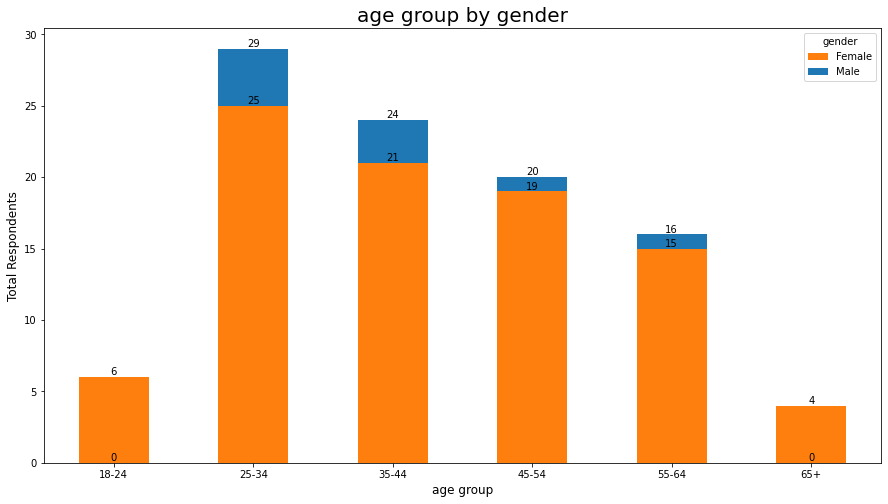

In [18]:
# age group by gender
agebygender = eda.groupby(["age_group", "gender"]).size().reset_index().pivot(columns="gender", index='age_group', values=0)
palette ={"Female": "C1", "Male": "C0"}
ax = agebygender.plot(kind="bar", stacked=True, rot=0, color=palette, figsize=(15,8))
for container in ax.containers:
    ax.bar_label(container)
plt.title( "age group by gender" , size = 20 )
plt.xlabel( "age group" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("2.jpg")
plt.show()

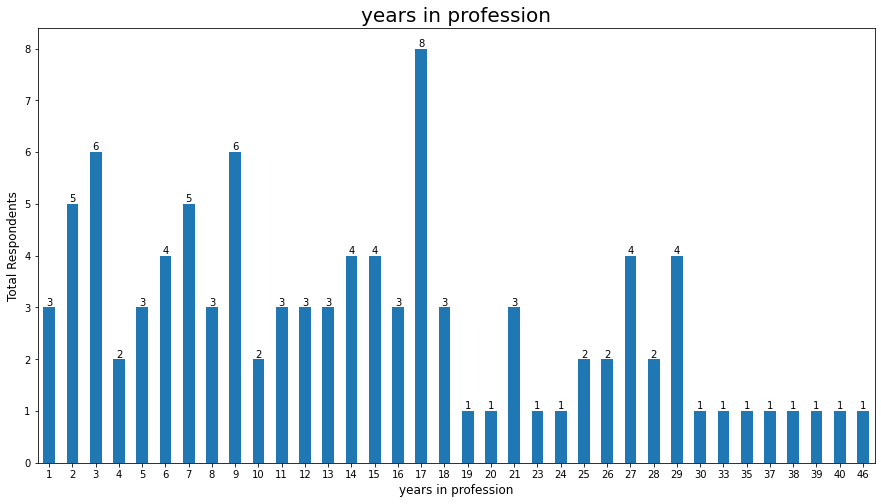

In [19]:
# years in profession
yearsinpro = eda.groupby(["years_in_profession"]).size()
ax = yearsinpro.plot(kind="bar", rot=0, figsize=(15,8))
for container in ax.containers:
    ax.bar_label(container)
plt.title( "years in profession" , size = 20 )
plt.xlabel( "years in profession" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("3.jpg")
plt.show()

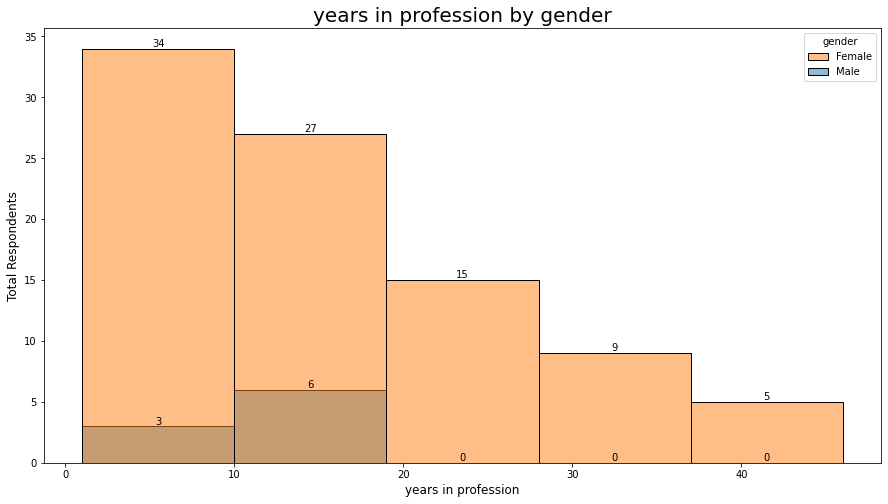

In [20]:
# years in profession by gender histogram
palette ={"Female": "C1", "Male": "C0"}
fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(data=eda, x="years_in_profession", bins=5, hue="gender", palette=palette, ax=ax)
for container in ax.containers:
    ax.bar_label(container)
plt.title( "years in profession by gender" , size = 20 )
plt.xlabel( "years in profession" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("4.jpg")
plt.show()

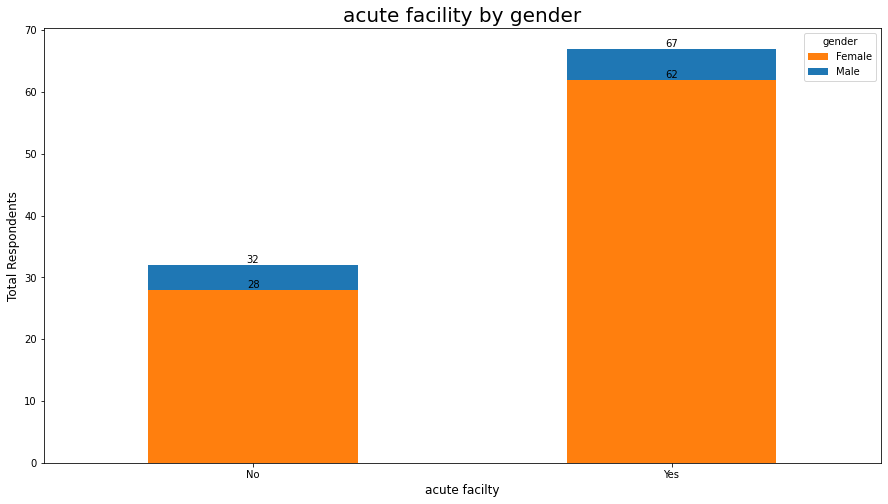

In [21]:
# facility by gender 
palette ={"Female": "C1", "Male": "C0"}
facilitybygender = eda.groupby(["is_cur_acute_facility", "gender"]).size().reset_index().pivot(columns="gender", index="is_cur_acute_facility", values=0)
ax = facilitybygender.plot(kind="bar", rot=0, stacked=True, color=palette, figsize=(15,8))
for container in ax.containers:
    ax.bar_label(container)
plt.title( "acute facility by gender" , size = 20 )
plt.xlabel( "acute facilty" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("5.jpg")
plt.show()

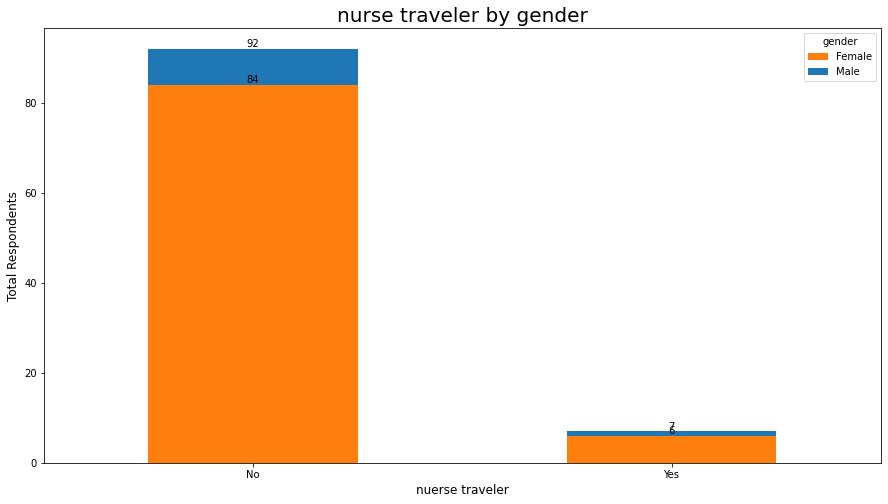

In [22]:
# nurese traveler by gender
palette ={"Female": "C1", "Male": "C0"}
travelerbygender = eda.groupby(["is_nurse_traveler", "gender"]).size().reset_index().pivot(columns="gender", index="is_nurse_traveler", values=0)
ax = travelerbygender.plot(kind="bar", rot=0, stacked=True, color=palette, figsize=(15,8))
for container in ax.containers:
    ax.bar_label(container)
plt.title( "nurse traveler by gender" , size = 20 )
plt.xlabel( "nuerse traveler" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("6.jpg")
plt.show()

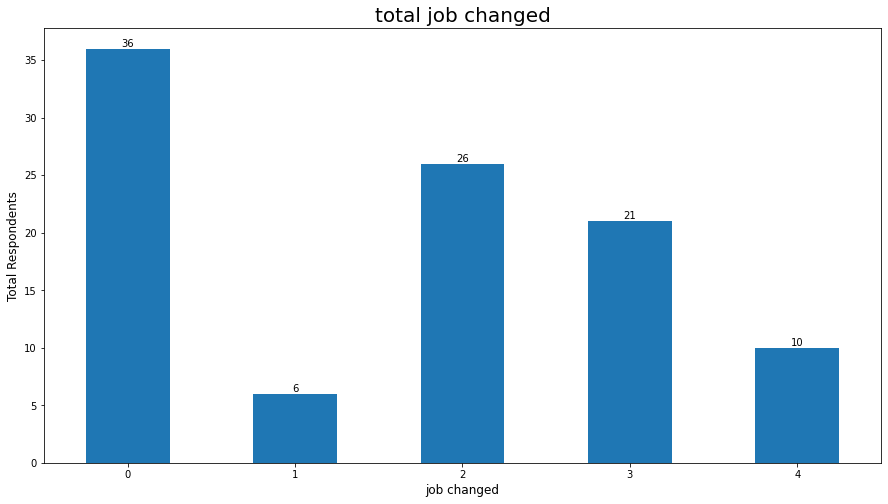

In [23]:
# total jobs changed
jobchanged = eda.groupby(["total_jobs_changed"]).size()
ax = jobchanged.plot(kind="bar", rot=0, figsize=(15,8))
for container in ax.containers:
    ax.bar_label(container)
plt.title( "total job changed" , size = 20 )
plt.xlabel( "job changed" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("7.jpg")
plt.show()

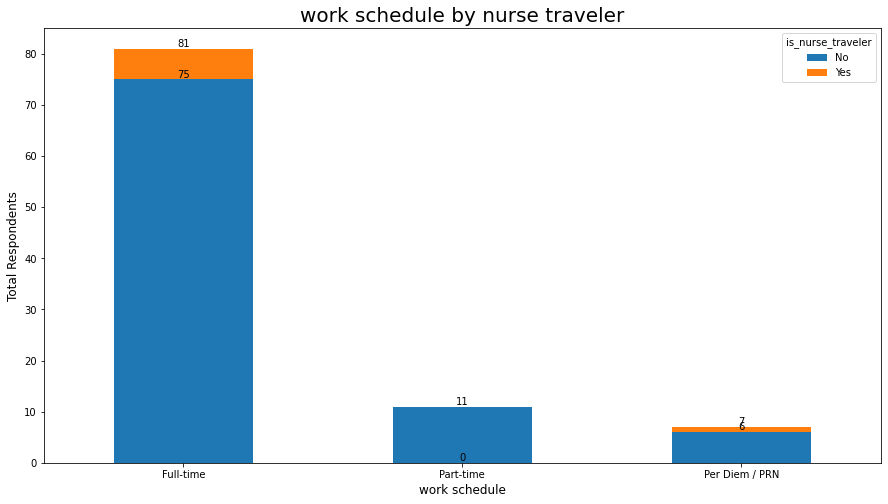

In [24]:
# work schedule by nurse traveler
schedule = eda.groupby(["cur_work_schedule", "is_nurse_traveler"]).size().reset_index().pivot(columns="is_nurse_traveler", index="cur_work_schedule", values=0)
ax = schedule.plot(kind="bar", rot=0, stacked=True, figsize=(15,8))
for container in ax.containers:
    ax.bar_label(container)
plt.title( "work schedule by nurse traveler" , size = 20 )
plt.xlabel( "work schedule" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("8.jpg")
plt.show()

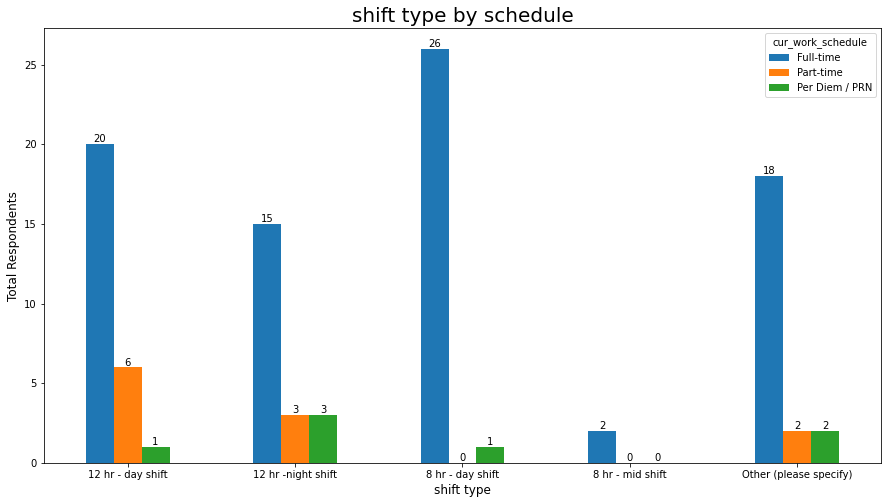

In [25]:
# shift type by schedule
shift = eda.groupby(["cur_shift_type", "cur_work_schedule"]).size().reset_index().pivot(columns="cur_work_schedule", index="cur_shift_type", values=0)
ax = shift.plot(kind="bar", rot=0, figsize=(15,8))
for container in ax.containers:
    ax.bar_label(container)
plt.title( "shift type by schedule" , size = 20 )
plt.xlabel( "shift type" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("9.jpg")
plt.show()

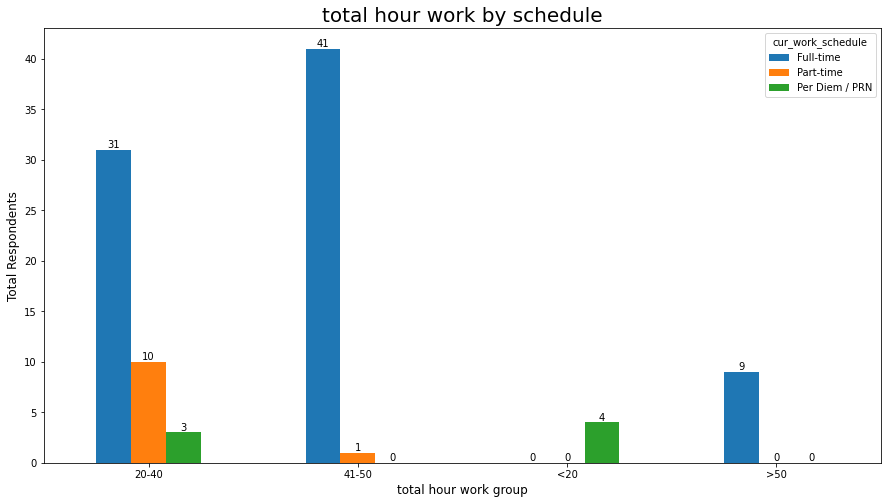

In [26]:
# total hour work group by schedule
workhour = eda.groupby(["cur_total_hour_work_group", "cur_work_schedule"]).size().reset_index().pivot(columns="cur_work_schedule", index="cur_total_hour_work_group", values=0)
ax = workhour.plot(kind="bar", rot=0, figsize=(15,8))
for container in ax.containers:
    ax.bar_label(container)
plt.title( "total hour work by schedule" , size = 20 )
plt.xlabel( "total hour work group" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("10.jpg")
plt.show()

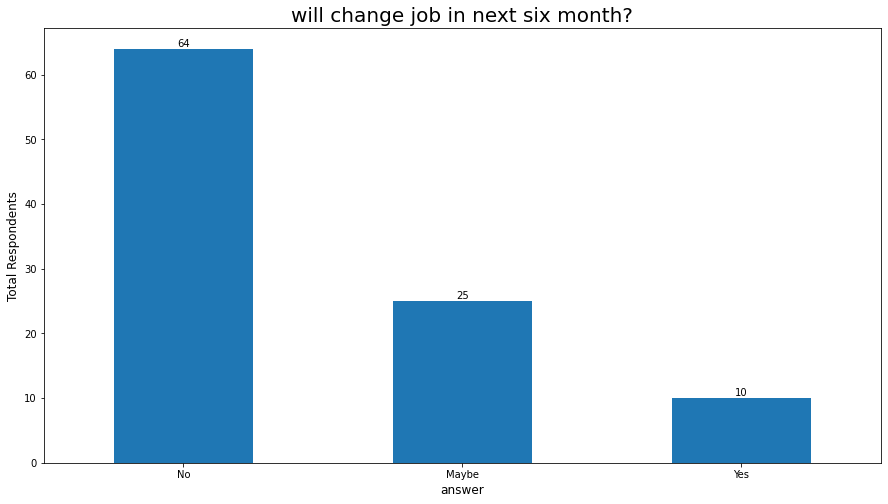

In [27]:
# plan to change job next 6 month
schedule = eda.groupby(["plan_to_change_next_6mo"]).size().sort_values(ascending=False)
ax = schedule.plot(kind="bar", rot=0, figsize=(15,8))
for container in ax.containers:
    ax.bar_label(container)
plt.title( "will change job in next six month?" , size = 20 )
plt.xlabel( "answer" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("11.jpg")
plt.show()

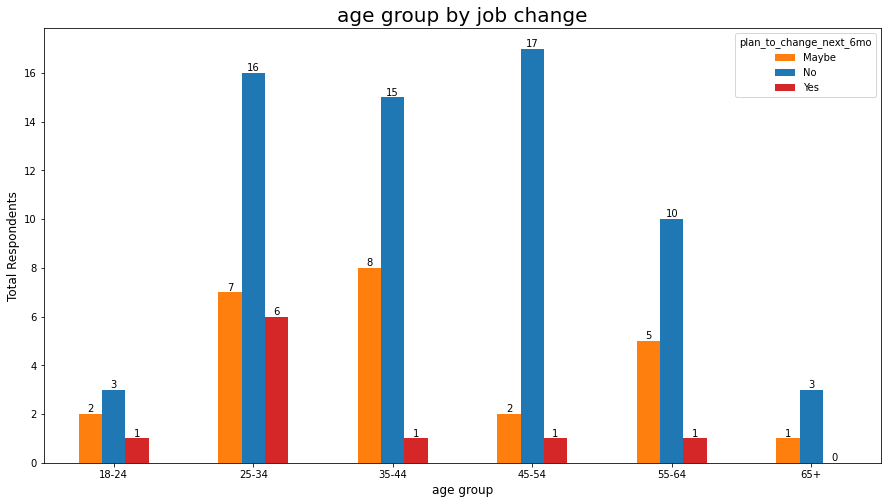

In [28]:
# age group by job change
palette1 = {"Yes":"C3", "No":"C0", "Maybe":"C1"}
agebychange = eda.groupby(["plan_to_change_next_6mo", "age_group"]).size().reset_index().pivot(columns="plan_to_change_next_6mo", index="age_group", values=0)
ax = agebychange.plot(kind="bar", rot=0, color=palette1, figsize=(15,8))
for container in ax.containers:
    ax.bar_label(container)
plt.title( "age group by job change" , size = 20 )
plt.xlabel( "age group" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("12.jpg")
plt.show()

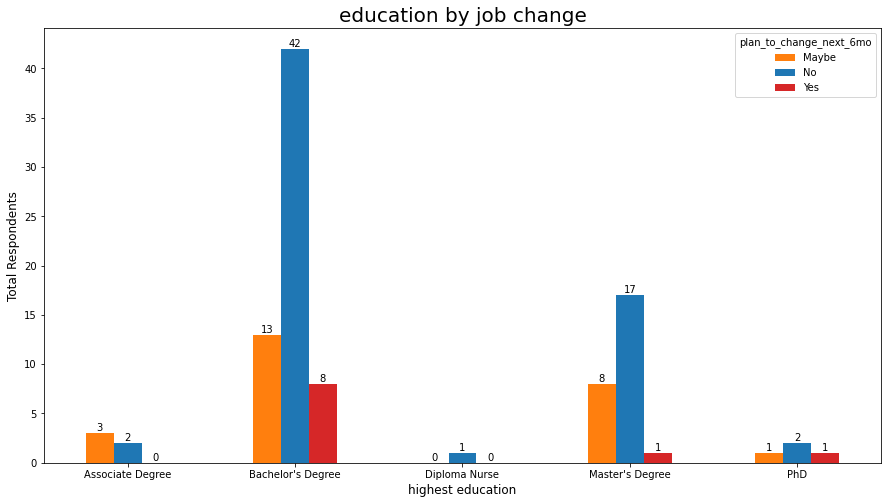

In [29]:
# highest education by job change
edubychange = eda.groupby(["plan_to_change_next_6mo", "highest_education"]).size().reset_index().pivot(columns="plan_to_change_next_6mo", index="highest_education", values=0)
ax = edubychange.plot(kind="bar", rot=0, color=palette1, figsize=(15,8))
for container in ax.containers:
    ax.bar_label(container)
plt.title( "education by job change" , size = 20 )
plt.xlabel( "highest education" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("13.jpg")
plt.show()

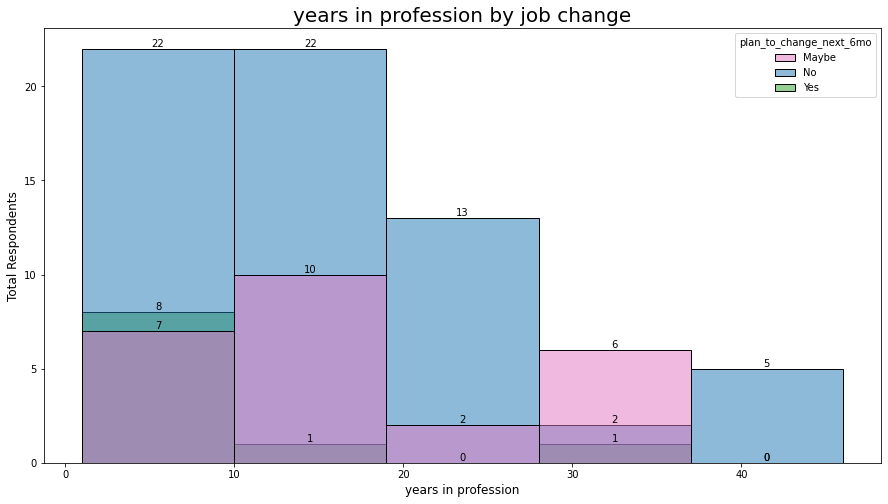

In [30]:
# years in profession by job change
palette2 = {"Yes":"C12", "No":"C0", "Maybe":"C6"}
fig, ax = plt.subplots(figsize=(15, 8))
sns.histplot(data=eda, x="years_in_profession", bins=5, hue="plan_to_change_next_6mo", palette=palette2, ax=ax)
for container in ax.containers:
    ax.bar_label(container)
plt.title( "years in profession by job change" , size = 20 )
plt.xlabel( "years in profession" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("14.jpg")
plt.show()

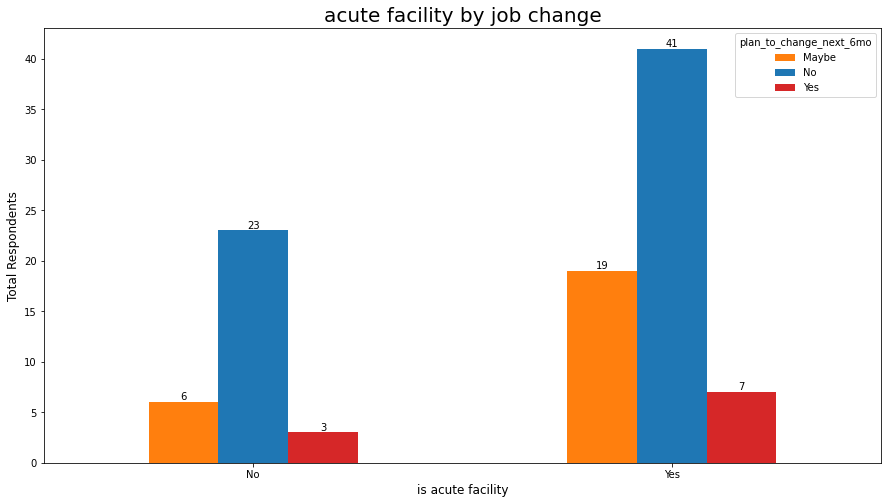

In [31]:
# acute facility by job change
facilitybychange = eda.groupby(["plan_to_change_next_6mo", "is_cur_acute_facility"]).size().reset_index().pivot(columns="plan_to_change_next_6mo", index="is_cur_acute_facility", values=0)
ax = facilitybychange.plot(kind="bar", rot=0, color=palette1, figsize=(15,8))
for container in ax.containers:
    ax.bar_label(container)
plt.title( "acute facility by job change" , size = 20 )
plt.xlabel( "is acute facility" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("15.jpg")
plt.show()

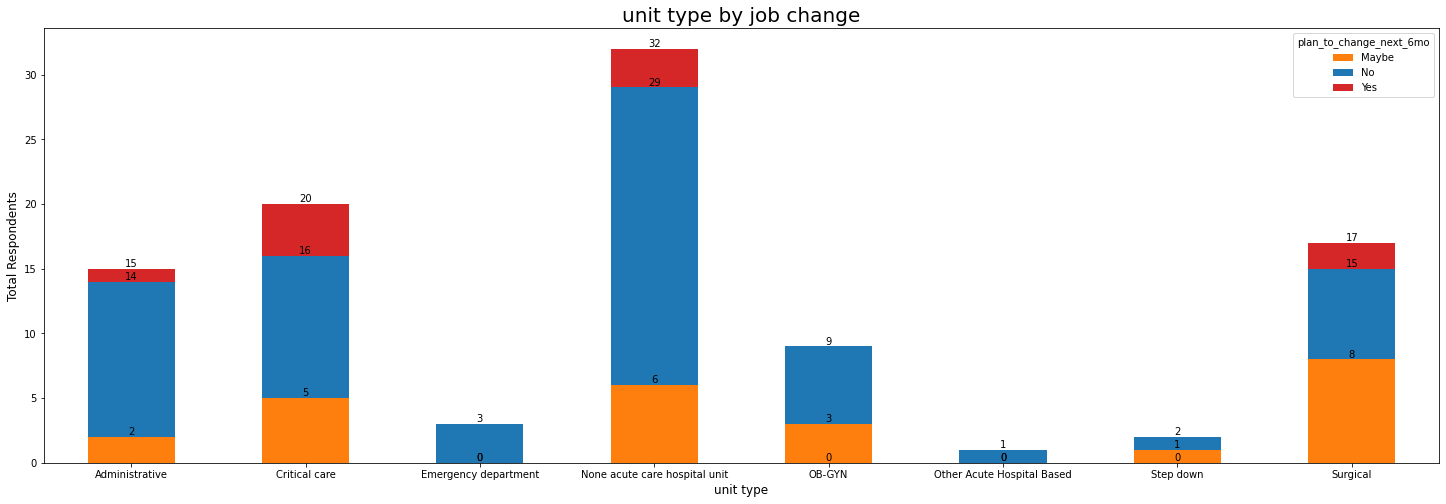

In [32]:
# unit group by job change
unitbychange = eda.groupby(["plan_to_change_next_6mo", "cur_acute_unit_group"]).size().reset_index().pivot(columns="plan_to_change_next_6mo", index="cur_acute_unit_group", values=0)
ax = unitbychange.plot(kind="bar", rot=0, color=palette1, stacked=True, figsize=(25,8))
for container in ax.containers:
    ax.bar_label(container)
plt.title( "unit type by job change" , size = 20 )
plt.xlabel( "unit type" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("16.jpg")
plt.show()

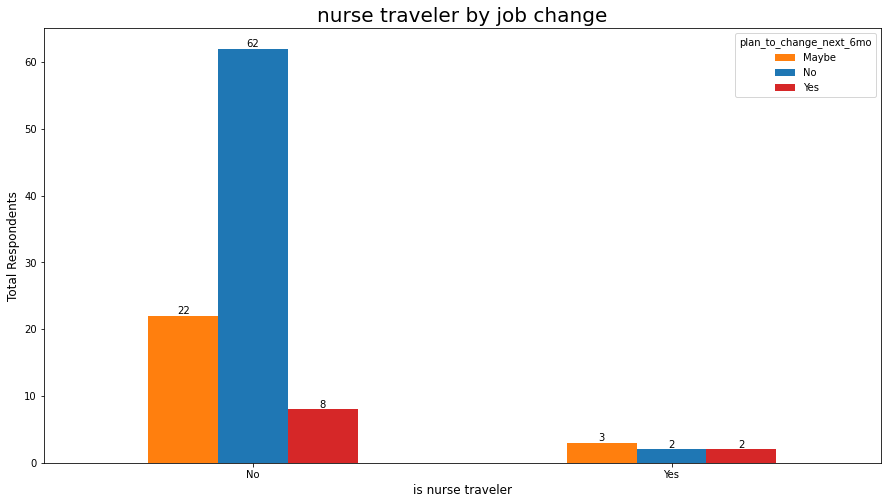

In [33]:
# is nursestraveler by job change
travelerbychange = eda.groupby(["plan_to_change_next_6mo", "is_nurse_traveler"]).size().reset_index().pivot(columns="plan_to_change_next_6mo", index="is_nurse_traveler", values=0)
ax = travelerbychange.plot(kind="bar", rot=0, color=palette1, figsize=(15,8))
for container in ax.containers:
    ax.bar_label(container)
plt.title( "nurse traveler by job change" , size = 20 )
plt.xlabel( "is nurse traveler" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("17.jpg")
plt.show()

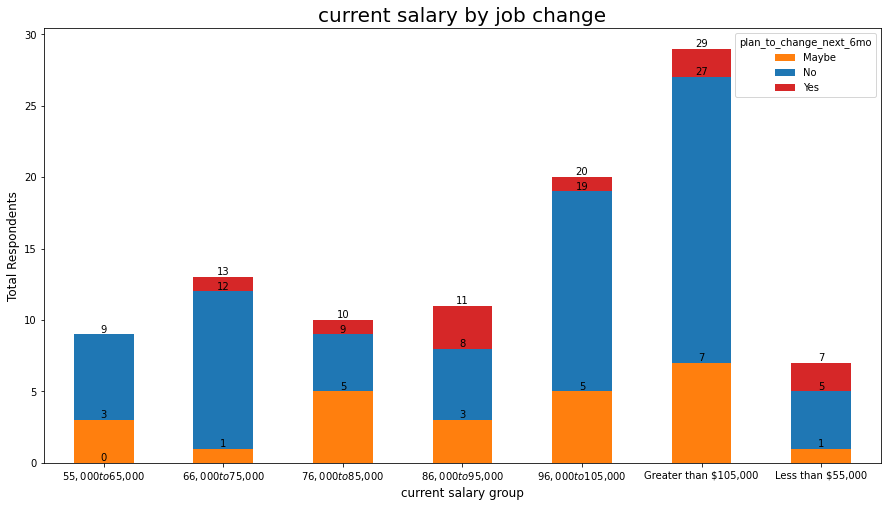

In [34]:
# annual range by job change
salbychange = eda.groupby(["plan_to_change_next_6mo", "cur_annual_range"]).size().reset_index().pivot(columns="plan_to_change_next_6mo", index="cur_annual_range", values=0)
ax = salbychange.plot(kind="bar", rot=0, stacked=True, color=palette1, figsize=(15,8))
for container in ax.containers:
    ax.bar_label(container)
plt.title( "current salary by job change" , size = 20 )
plt.xlabel( "current salary group" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("18.jpg")
plt.show()

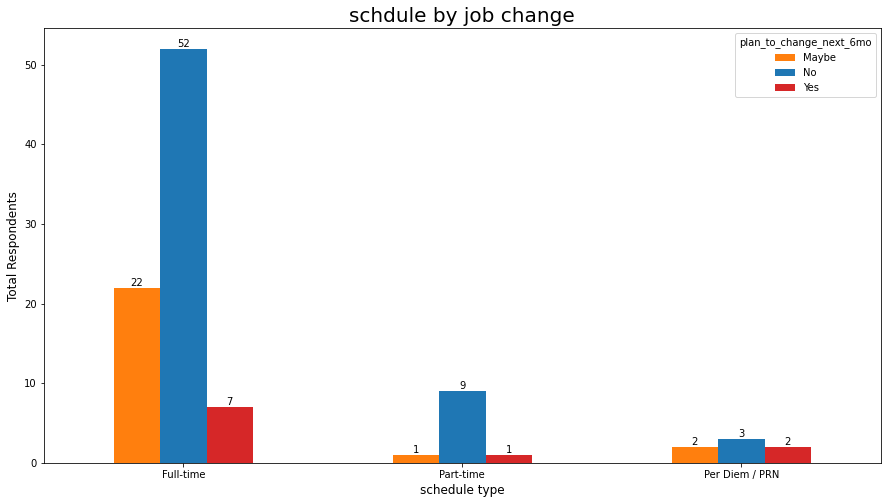

In [35]:
# work schedule by job change
schedulebychange = eda.groupby(["plan_to_change_next_6mo", "cur_work_schedule"]).size().reset_index().pivot(columns="plan_to_change_next_6mo", index="cur_work_schedule", values=0)
ax = schedulebychange.plot(kind="bar", rot=0, color=palette1, figsize=(15,8))
for container in ax.containers:
    ax.bar_label(container)
plt.title( "schdule by job change" , size = 20 )
plt.xlabel( "schedule type" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("19.jpg")
plt.show()

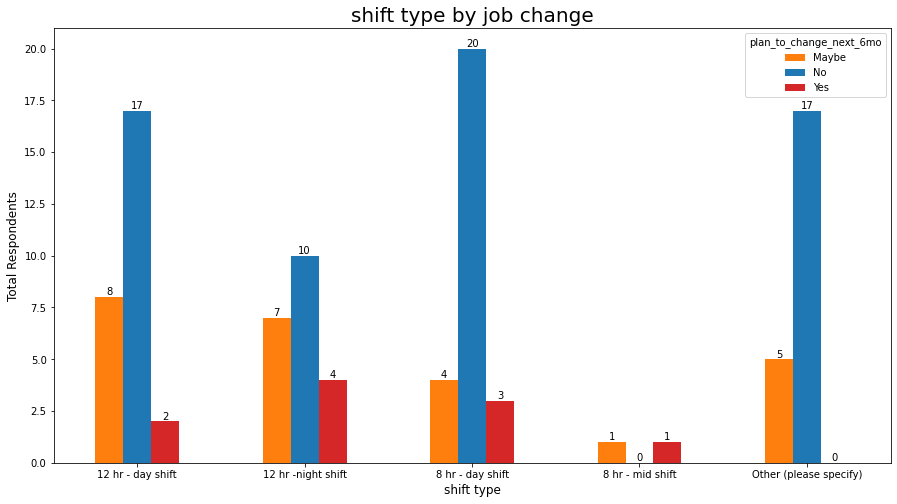

In [36]:
# shift type by job change
shiftbychange = eda.groupby(["plan_to_change_next_6mo", "cur_shift_type"]).size().reset_index().pivot(columns="plan_to_change_next_6mo", index="cur_shift_type", values=0)
ax = shiftbychange.plot(kind="bar", rot=0, color=palette1, figsize=(15,8))
for container in ax.containers:
    ax.bar_label(container)
plt.title( "shift type by job change" , size = 20 )
plt.xlabel( "shift type" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("20.jpg")
plt.show()

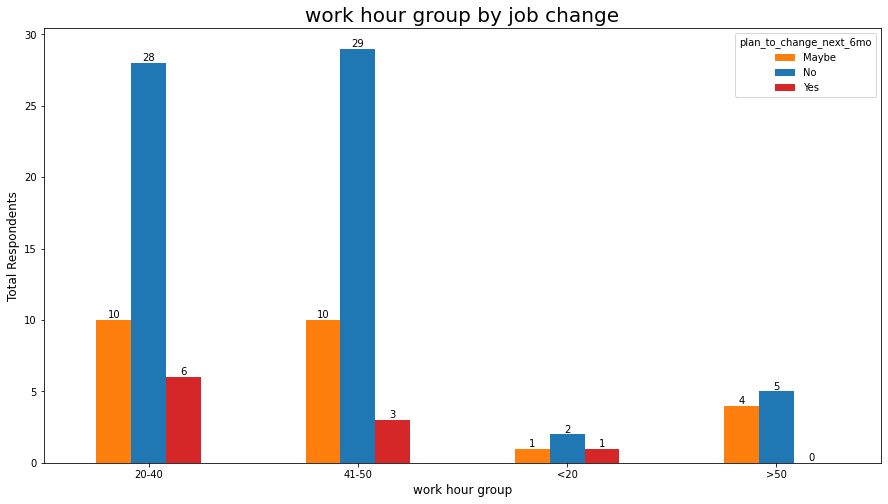

In [37]:
# total hour work group by job change
hourbychange = eda.groupby(["plan_to_change_next_6mo", "cur_total_hour_work_group"]).size().reset_index().pivot(columns="plan_to_change_next_6mo", index="cur_total_hour_work_group", values=0)
ax = hourbychange.plot(kind="bar", rot=0, color=palette1, figsize=(15,8))
for container in ax.containers:
    ax.bar_label(container)
plt.title( "work hour group by job change" , size = 20 )
plt.xlabel( "work hour group" , size = 12 )
plt.ylabel( "Total Respondents" , size = 12 )
plt.savefig("21.jpg")
plt.show()

## Predictive

In [38]:
# create model df
pdf = eda.iloc[:, np.r_[0:6, 7:10, 11, 13, 15, 16, 18, 19, 20]].reset_index(drop=True)
pdf = pdf[pdf["plan_to_change_next_6mo"]!="Maybe"]
pdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 1 to 94
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   years_in_profession        74 non-null     int64 
 1   cur_highest_license        74 non-null     object
 2   cur_licensed_state_type    74 non-null     object
 3   age_group                  74 non-null     object
 4   gender                     74 non-null     object
 5   highest_education          74 non-null     object
 6   len_of_cur_license_level   74 non-null     object
 7   is_cur_acute_facility      74 non-null     object
 8   cur_acute_unit_group       74 non-null     object
 9   is_nurse_traveler          74 non-null     object
 10  cur_annual_range           74 non-null     object
 11  total_jobs_changed         74 non-null     int64 
 12  plan_to_change_next_6mo    74 non-null     object
 13  cur_work_schedule          74 non-null     object
 14  cur_shift_ty

In [39]:
# separate cont and cat variables
cont_df = pdf.iloc[:, [0,11]]
cat_df = pdf.loc[:, ~pdf.columns.isin(pdf.iloc[:, [0,11]])]

### correlation

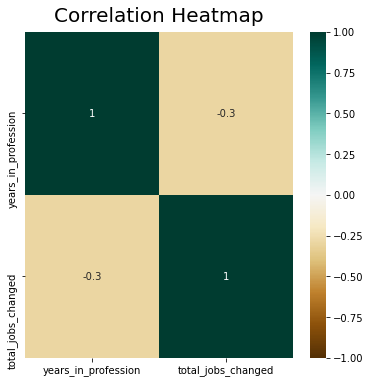

In [40]:
# correlation graph
plt.figure(figsize=(6, 6))
heatmap = sns.heatmap(cont_df.corr(), vmin=-1, vmax=1, annot=True, cmap='BrBG')
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':20}, pad=10)
plt.savefig("22.jpg")

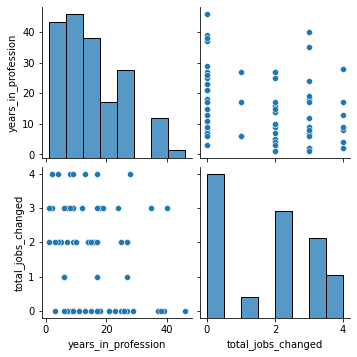

In [41]:
# pairplot 
sns.pairplot(cont_df#, kind="hist"
            )
plt.savefig("23.jpg")

### chi-square test for independence

In [42]:
# chi-sqaure test pairing
chi_var1 = cat_df.columns
chi_var2 = cat_df.columns
chi_var_prod = list(product(chi_var1,chi_var2, repeat = 1))
chi_var_prod

[('cur_highest_license', 'cur_highest_license'),
 ('cur_highest_license', 'cur_licensed_state_type'),
 ('cur_highest_license', 'age_group'),
 ('cur_highest_license', 'gender'),
 ('cur_highest_license', 'highest_education'),
 ('cur_highest_license', 'len_of_cur_license_level'),
 ('cur_highest_license', 'is_cur_acute_facility'),
 ('cur_highest_license', 'cur_acute_unit_group'),
 ('cur_highest_license', 'is_nurse_traveler'),
 ('cur_highest_license', 'cur_annual_range'),
 ('cur_highest_license', 'plan_to_change_next_6mo'),
 ('cur_highest_license', 'cur_work_schedule'),
 ('cur_highest_license', 'cur_shift_type'),
 ('cur_highest_license', 'cur_total_hour_work_group'),
 ('cur_licensed_state_type', 'cur_highest_license'),
 ('cur_licensed_state_type', 'cur_licensed_state_type'),
 ('cur_licensed_state_type', 'age_group'),
 ('cur_licensed_state_type', 'gender'),
 ('cur_licensed_state_type', 'highest_education'),
 ('cur_licensed_state_type', 'len_of_cur_license_level'),
 ('cur_licensed_state_type'

In [43]:
# chi-sqaure result
chi_result = []
for i in chi_var_prod:
    if i[0] != i[1]:
        chi_result.append((i[0],i[1],list(ss.chi2_contingency(pd.crosstab(cat_df[i[0]], cat_df[i[1]])))[1])) 

In [44]:
# get output in df
chi_test_output = pd.DataFrame(chi_result, columns = ["var1", "var2", "coeff"])
## Using pivot function to convert the above DataFrame into a crosstab
chi_test_output.pivot(index="var1", columns="var2", values="coeff")

var2,age_group,cur_acute_unit_group,cur_annual_range,cur_highest_license,cur_licensed_state_type,cur_shift_type,cur_total_hour_work_group,cur_work_schedule,gender,highest_education,is_cur_acute_facility,is_nurse_traveler,len_of_cur_license_level,plan_to_change_next_6mo
var1,,,,,,,,,,,,,,
age_group,NaN,1.844126e-01,0.001474,9.675944e-01,0.180965,0.001862,3.957111e-02,9.141588e-01,0.892128,5.098600e-01,2.958613e-01,0.416564,7.659614e-18,0.272247
cur_acute_unit_group,1.844126e-01,NaN,0.001495,9.748370e-01,0.927574,0.000246,1.237837e-02,3.660878e-03,0.270000,2.014542e-01,2.288524e-13,0.207522,1.332858e-01,0.661562
cur_annual_range,1.474405e-03,1.494705e-03,NaN,1.392127e-01,0.479929,0.000479,2.416074e-06,1.003620e-04,0.460179,1.156573e-02,5.423397e-01,0.262219,1.056275e-01,0.215732
cur_highest_license,9.675944e-01,9.748370e-01,0.139213,NaN,0.991554,0.752624,9.184773e-01,4.054643e-01,0.801800,8.812936e-15,1.906816e-01,0.886197,1.136873e-01,0.551456
cur_licensed_state_type,1.809654e-01,9.275742e-01,0.479929,9.915543e-01,NaN,0.785907,4.611508e-02,4.431314e-01,0.116014,1.556318e-01,4.344781e-01,0.004066,7.077853e-02,0.014845
cur_shift_type,1.862330e-03,2.455855e-04,0.000479,7.526244e-01,0.785907,NaN,7.723666e-04,1.317418e-01,0.289361,5.993267e-03,2.152548e-03,0.656117,5.218006e-01,0.017943
cur_total_hour_work_group,3.957111e-02,1.237837e-02,0.000002,9.184773e-01,0.046115,0.000772,NaN,9.505895e-10,0.468971,4.183115e-03,6.946998e-03,0.668612,4.838587e-01,0.430863
cur_work_schedule,9.141588e-01,3.660878e-03,0.000100,4.054643e-01,0.443131,0.131742,9.505895e-10,NaN,0.421448,5.879764e-01,1.306779e-01,0.584189,8.827950e-01,0.197487
gender,8.921280e-01,2.700003e-01,0.460179,8.018004e-01,0.116014,0.289361,4.689713e-01,4.214476e-01,NaN,4.465216e-01,9.730908e-01,0.830824,8.062363e-02,0.604355


In [45]:
# print variables that are dependent
for i in chi_result:
    if i[2] <= 0.05: 
        sig_result = i
        print(sig_result)  

('cur_highest_license', 'highest_education', 8.812936088490821e-15)
('cur_licensed_state_type', 'is_nurse_traveler', 0.004066078620224604)
('cur_licensed_state_type', 'plan_to_change_next_6mo', 0.014844509365393704)
('cur_licensed_state_type', 'cur_total_hour_work_group', 0.04611507824556424)
('age_group', 'len_of_cur_license_level', 7.659613730888451e-18)
('age_group', 'cur_annual_range', 0.0014744051932393085)
('age_group', 'cur_shift_type', 0.0018623302908748975)
('age_group', 'cur_total_hour_work_group', 0.039571107272766165)
('highest_education', 'cur_highest_license', 8.812936088490757e-15)
('highest_education', 'cur_annual_range', 0.011565731223208954)
('highest_education', 'cur_shift_type', 0.005993266562869221)
('highest_education', 'cur_total_hour_work_group', 0.00418311483658792)
('len_of_cur_license_level', 'age_group', 7.659613730888451e-18)
('len_of_cur_license_level', 'is_nurse_traveler', 0.002325043927769293)
('len_of_cur_license_level', 'plan_to_change_next_6mo', 0.032

### logistic regression

In [46]:
pdf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74 entries, 1 to 94
Data columns (total 16 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   years_in_profession        74 non-null     int64 
 1   cur_highest_license        74 non-null     object
 2   cur_licensed_state_type    74 non-null     object
 3   age_group                  74 non-null     object
 4   gender                     74 non-null     object
 5   highest_education          74 non-null     object
 6   len_of_cur_license_level   74 non-null     object
 7   is_cur_acute_facility      74 non-null     object
 8   cur_acute_unit_group       74 non-null     object
 9   is_nurse_traveler          74 non-null     object
 10  cur_annual_range           74 non-null     object
 11  total_jobs_changed         74 non-null     int64 
 12  plan_to_change_next_6mo    74 non-null     object
 13  cur_work_schedule          74 non-null     object
 14  cur_shift_ty

In [47]:
pdf["plan_to_change"] = np.where(pdf["plan_to_change_next_6mo"]=="Yes", 1, 0)

In [48]:
dummy_df = pd.get_dummies(pdf, columns=["cur_highest_license","cur_licensed_state_type","age_group","gender","highest_education","len_of_cur_license_level",
                                        "is_cur_acute_facility","cur_acute_unit_group","is_nurse_traveler","cur_annual_range","cur_work_schedule","cur_shift_type",
                                        "cur_total_hour_work_group"])
independent_var = dummy_df.drop(["plan_to_change", "plan_to_change_next_6mo"], axis=1).values
target_var = pdf[["plan_to_change"]].values

In [49]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(independent_var, target_var, test_size=0.20, random_state=10)

In [50]:
#import class
from sklearn.linear_model import LogisticRegression

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=10)

# fit the model with data
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

/Users/ryry/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [51]:
from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

array([[13,  0],
       [ 2,  0]])

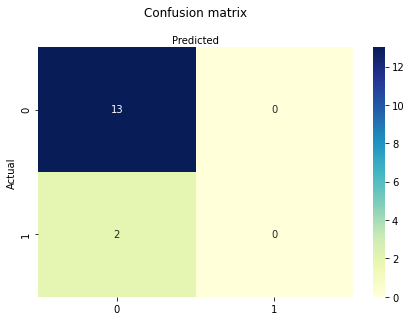

In [52]:
class_names=[0,1]
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt="g")
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title("Confusion matrix", y=1.1)
plt.ylabel("Actual")
plt.xlabel("Predicted")
plt.savefig("24.jpg")

In [53]:
from sklearn.metrics import classification_report
target_names = ["0", "1"]
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

           0       0.87      1.00      0.93        13
           1       0.00      0.00      0.00         2

    accuracy                           0.87        15
   macro avg       0.43      0.50      0.46        15
weighted avg       0.75      0.87      0.80        15



/Users/ryry/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ryry/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ryry/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegressionCV(max_iter=20000, multi_class='auto', cv=5)
results = model.fit(independent_var, target_var.ravel())
print(model.score(independent_var, target_var.ravel()))

0.8648648648648649


In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_validate

In [56]:
models = LogisticRegression()
scores = cross_validate(models, independent_var, target_var, scoring='accuracy', cv=10)
print(scores['test_score'])

[0.875      0.75       0.875      0.75       0.85714286 0.85714286
 0.85714286 0.85714286 0.85714286 0.71428571]


/Users/ryry/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ryry/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ryry/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/ryry/opt/anaconda3/lib/python3.8/site-packages/sklearn/utils/validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected.